In [72]:
%matplotlib inline

import statsmodels as sm
import xarray as xr

import matplotlib.pyplot as plt

In [2]:
ncfiles = {}
# Grid and domain files
ncfiles['rasm_domain'] = '/raid2/jhamman/projects/RASM/data/inputdata/CESM/share/domains/domain.lnd.wr50a_ar9v4.100920.nc'
ncfiles['rasm_lnd_masks'] = '/raid2/jhamman/projects/RASM/data/inputdata/RASM_VICRVIC_GRID_MASKS_AND_METRICS.nc'
ncfiles['rasm_ocn_masks'] = '/raid2/jhamman/projects/RASM/data/inputdata/RASM_WRFVIC_GRID_MASKS_AND_METRICS.nc'

ncfiles['$RASM_{CONTROL}$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbaaa01a/cpl/monthly_mean_timeseries/R1010RBRbaaa01a.cpl.hmm.197909-201412.nc'


ds = xr.open_dataset(ncfiles['$RASM_{CONTROL}$'])

ncdata = {}
for k, v in ncfiles.items():
    ncdata[k] = xr.open_dataset(v)
    
ncdata['rasm_ocn_masks'] = ncdata['rasm_ocn_masks'].rename({'y': 'nj', 'x': 'ni'})
ncdata['$RASM_{CONTROL}$'] = ncdata['$RASM_{CONTROL}$'].rename({'a2xavg_nx': 'ni',
 'a2xavg_ny': 'nj',
 'l2xavg_nx': 'ni',
 'l2xavg_ny': 'nj',
 'x2aavg_nx': 'ni',
 'x2aavg_ny': 'nj',
 'x2lavg_nx': 'ni',
 'x2lavg_ny': 'nj'})

In [3]:
re = 6.37122e6
ncdata['rasm_domain']['area'] *= re * re  # m2

In [25]:
total_precip = ds.a2xavg_Faxa_rainc + ds.a2xavg_Faxa_rainl + ds.a2xavg_Faxa_snowc + ds.a2xavg_Faxa_snowl
p = total_precip.sel(time=ds.indexes['time'].month > 9).rename({'a2xavg_ny': 'nj', 'a2xavg_nx': 'ni'})
p = p.resample('AS', how='mean', dim='time') * 86400 * 92 / 1000  # m

e = ds.x2aavg_Faxx_evap.sel(time=ds.indexes['time'].month > 9).rename({'x2aavg_ny': 'nj', 'x2aavg_nx': 'ni'})
e = e.resample('AS', how='mean', dim='time') * 86400 * 92 / 1000  # m

In [54]:
pmt = ((p - e) * ncdata['rasm_domain']['area'] / 1000 / 1000 / 1000).where(ncdata['rasm_domain'].yc > 60) # km3

In [58]:
pmt_series = pmt.sum(('ni', 'nj')).to_series()

In [67]:
e_ocn = ((p - e) * ncdata['rasm_domain']['area'] / 1000 / 1000 / 1000).where(
    (ncdata['rasm_ocn_masks']['mask_centralarctic'] +
     ncdata['rasm_ocn_masks']['mask_barents'] +
     ncdata['rasm_ocn_masks']['mask_kara']))

In [68]:
e_ocn_series = e_ocn.sum(('ni', 'nj')).to_series()

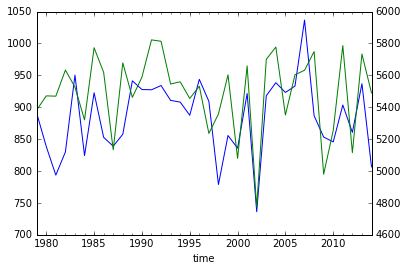

In [71]:
e_ocn_series.plot()
pmt_series.plot(secondary_y=True)

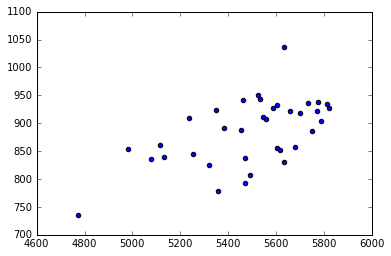

In [73]:
plt.scatter(pmt_series, e_ocn_series)